# Sprint 4 - CNN Melhorada Treinada do Zero

Este notebook implementa melhorias significativas baseadas na Sprint 1, mas com treinamento do zero e técnicas avançadas:

- **Treinamento do Zero**: Modelos customizados treinados do zero (não transfer learning)
- **Data Augmentation Avançada**: Técnicas de aumento de dados para melhorar a generalização
- **Arquiteturas Customizadas**: CNNs otimizadas para o problema específico
- **Learning Rate Scheduling**: Ajuste dinâmico da taxa de aprendizado
- **Early Stopping**: Prevenção de overfitting
- **Métricas Avançadas**: Acompanhamento detalhado do desempenho
- **Visualizações Completas**: Gráficos de treinamento e análise de resultados

## Classes de Doenças:
- **Cerscospora**: Mancha de Cercospora
- **Healthy**: Folha saudável
- **Leaf rust**: Ferrugem da folha
- **Miner**: Minador da folha
- **Phoma**: Mancha de Phoma


In [1]:
# Download dos Datasets do Kaggle
import kagglehub

print("📥 Baixando datasets de doenças em folhas de café...")

# Download dos datasets
noamaanabdulazeem_jmuben_coffee_dataset_path = kagglehub.dataset_download('noamaanabdulazeem/jmuben-coffee-dataset')
gauravduttakiit_coffee_leaf_diseases_path = kagglehub.dataset_download('gauravduttakiit/coffee-leaf-diseases')
biniyamyoseph_ethiopian_coffee_leaf_disease_path = kagglehub.dataset_download('biniyamyoseph/ethiopian-coffee-leaf-disease')
mohammedzwaughfa_coffee_leaf_disease_dataset_path = kagglehub.dataset_download('mohammedzwaughfa/coffee-leaf-disease-dataset')

print('✅ Download dos datasets concluído!')
print(f"Dataset 1: {noamaanabdulazeem_jmuben_coffee_dataset_path}")
print(f"Dataset 2: {gauravduttakiit_coffee_leaf_diseases_path}")
print(f"Dataset 3: {biniyamyoseph_ethiopian_coffee_leaf_disease_path}")
print(f"Dataset 4: {mohammedzwaughfa_coffee_leaf_disease_dataset_path}")


📥 Baixando datasets de doenças em folhas de café...
✅ Download dos datasets concluído!
Dataset 1: /home/t21-g112/.cache/kagglehub/datasets/noamaanabdulazeem/jmuben-coffee-dataset/versions/2
Dataset 2: /home/t21-g112/.cache/kagglehub/datasets/gauravduttakiit/coffee-leaf-diseases/versions/1
Dataset 3: /home/t21-g112/.cache/kagglehub/datasets/biniyamyoseph/ethiopian-coffee-leaf-disease/versions/1
Dataset 4: /home/t21-g112/.cache/kagglehub/datasets/mohammedzwaughfa/coffee-leaf-disease-dataset/versions/1


In [2]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, StepLR
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
from pathlib import Path
import time
import json
from collections import defaultdict, Counter
import warnings
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cuda
GPU: NVIDIA RTX 4000 Ada Generation
CUDA Version: 12.8
Memory: 19.5 GB


In [3]:
# Configuration for Sprint 4 - Improved from Sprint 1
CONFIG = {
    'img_size': 224,
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'patience': 10,  # For early stopping
    'min_delta': 0.001,  # Minimum change to qualify as improvement
    'subset_fraction': 0.8,  # Use 80% of data for training
    
    # Data paths - using local directories
    'data_dir': './data/coffee_leaf_diseases',  # Local data directory
    'save_dir': './modelos/sprint-4',  # For saving new models
    'test_images_dir': './assets/img-tests',  # Test images directory
    
    # Class information
    'class_names': ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma'],
    'num_classes': 5,
    
    # Model configurations
    'models_to_train': ['CustomCNN1', 'CustomCNN2', 'CustomCNN3'],
    
    # Training parameters
    'use_mixed_precision': True,
    'gradient_clip_norm': 1.0,
    'scheduler_type': 'cosine',  # 'cosine', 'plateau', 'step'
    
    # Data augmentation
    'use_advanced_augmentation': True,
    'mixup_alpha': 0.2,
    'cutmix_alpha': 1.0,
    'label_smoothing': 0.1
}

print("Configuration loaded successfully!")
print(f"Number of classes: {CONFIG['num_classes']}")
print(f"Classes: {CONFIG['class_names']}")
print(f"Models to train: {CONFIG['models_to_train']}")
print(f"Advanced augmentation: {CONFIG['use_advanced_augmentation']}")
print(f"Data directory: {CONFIG['data_dir']}")


Configuration loaded successfully!
Number of classes: 5
Classes: ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']
Models to train: ['CustomCNN1', 'CustomCNN2', 'CustomCNN3']
Advanced augmentation: True
Data directory: ./data/coffee_leaf_diseases


In [4]:
# Advanced Data Augmentation - Improved from Sprint 1
class AdvancedTransforms:
    """Advanced data augmentation techniques for better model generalization"""
    
    @staticmethod
    def get_train_transforms(img_size=224):
        """Get training transforms with advanced augmentation"""
        return transforms.Compose([
            transforms.Resize((img_size + 32, img_size + 32)),
            transforms.RandomCrop(img_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3))
        ])
    
    @staticmethod
    def get_val_transforms(img_size=224):
        """Get validation transforms (minimal augmentation)"""
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

# Mixup and CutMix implementations
def mixup_data(x, y, alpha=1.0):
    """Apply mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup loss function"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def cutmix_data(x, y, alpha=1.0):
    """Apply CutMix augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    
    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    
    # Adjust lambda
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam

def rand_bbox(size, lam):
    """Generate random bounding box for CutMix"""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    
    # Uniform sampling
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    return bbx1, bby1, bbx2, bby2

print("Advanced data augmentation functions loaded successfully!")


Advanced data augmentation functions loaded successfully!


In [5]:
# Custom CNN Architectures - Trained from Scratch
class CustomCNN1(nn.Module):
    """Custom CNN Architecture 1 - Lightweight but effective"""
    def __init__(self, num_classes=5):
        super(CustomCNN1, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class CustomCNN2(nn.Module):
    """Custom CNN Architecture 2 - Deeper with residual connections"""
    def __init__(self, num_classes=5):
        super(CustomCNN2, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    
    def _make_layer(self, inplanes, planes, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(inplanes, planes, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(planes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class BasicBlock(nn.Module):
    """Basic residual block"""
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CustomCNN3(nn.Module):
    """Custom CNN Architecture 3 - EfficientNet-inspired"""
    def __init__(self, num_classes=5):
        super(CustomCNN3, self).__init__()
        
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # MBConv blocks
        self.blocks = nn.Sequential(
            MBConv(32, 16, 1, 1),
            MBConv(16, 24, 6, 2),
            MBConv(24, 40, 6, 2),
            MBConv(40, 80, 6, 2),
            MBConv(80, 112, 6, 1),
            MBConv(112, 192, 6, 2),
            MBConv(192, 320, 6, 1),
        )
        
        # Head
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1),
            nn.BatchNorm2d(1280),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x

class MBConv(nn.Module):
    """Mobile Inverted Bottleneck Convolution"""
    def __init__(self, in_channels, out_channels, expansion_factor, stride):
        super(MBConv, self).__init__()
        self.stride = stride
        self.use_residual = stride == 1 and in_channels == out_channels
        
        expanded_channels = in_channels * expansion_factor
        
        # Expansion
        self.expand = nn.Conv2d(in_channels, expanded_channels, 1, bias=False)
        self.expand_bn = nn.BatchNorm2d(expanded_channels)
        
        # Depthwise
        self.depthwise = nn.Conv2d(expanded_channels, expanded_channels, 3, stride, 1, groups=expanded_channels, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(expanded_channels)
        
        # Projection
        self.project = nn.Conv2d(expanded_channels, out_channels, 1, bias=False)
        self.project_bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        residual = x
        
        x = F.relu(self.expand_bn(self.expand(x)))
        x = F.relu(self.depthwise_bn(self.depthwise(x)))
        x = self.project_bn(self.project(x))
        
        if self.use_residual:
            x += residual
        
        return x

# Import F for activation functions
import torch.nn.functional as F

print("Custom CNN architectures loaded successfully!")


Custom CNN architectures loaded successfully!


🔍 Loading and exploring datasets...
Loaded dataset from /home/t21-g112/.cache/kagglehub/datasets/mohammedzwaughfa/coffee-leaf-disease-dataset/versions/1/dataset/test: 400 samples
Loaded dataset from /home/t21-g112/.cache/kagglehub/datasets/gauravduttakiit/coffee-leaf-diseases/versions/1/train: 1264 samples
Loaded dataset from /home/t21-g112/.cache/kagglehub/datasets/gauravduttakiit/coffee-leaf-diseases/versions/1/test: 400 samples
Loaded dataset from /home/t21-g112/.cache/kagglehub/datasets/biniyamyoseph/ethiopian-coffee-leaf-disease/versions/1/ethiopian cofee leaf dataset/train aug: 10800 samples
Loaded dataset from /home/t21-g112/.cache/kagglehub/datasets/biniyamyoseph/ethiopian-coffee-leaf-disease/versions/1/ethiopian cofee leaf dataset/test: 1200 samples
Loaded dataset from /home/t21-g112/.cache/kagglehub/datasets/noamaanabdulazeem/jmuben-coffee-dataset/versions/2/JMuBEN: 58549 samples

Dataset: test
Class Distribution:
Healthy: 100
Miner: 100
Phoma: 100
Rust: 100


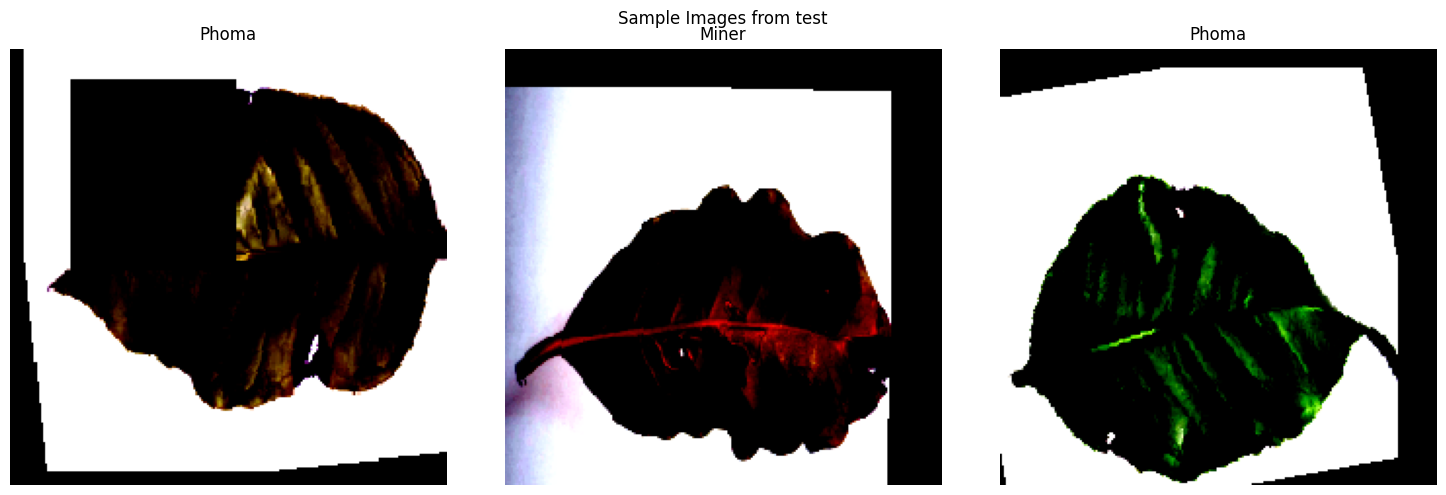


Dataset: train
Class Distribution:
miner: 332
nodisease: 284
phoma: 388
rust: 260


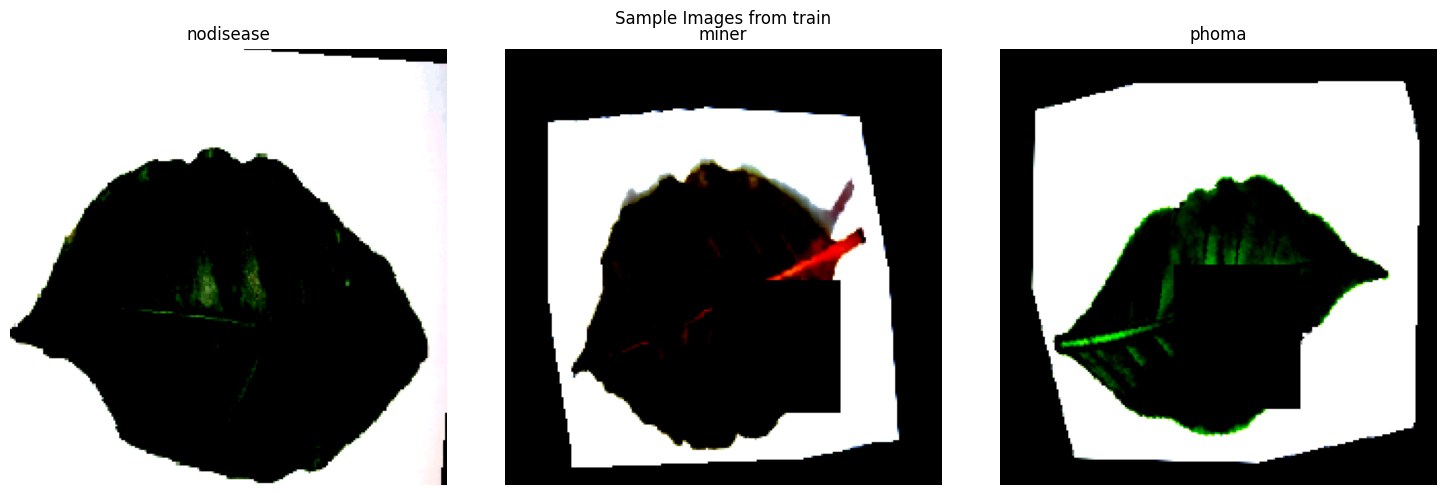


Dataset: test
Class Distribution:
miner: 128
nodisease: 116
phoma: 96
rust: 60


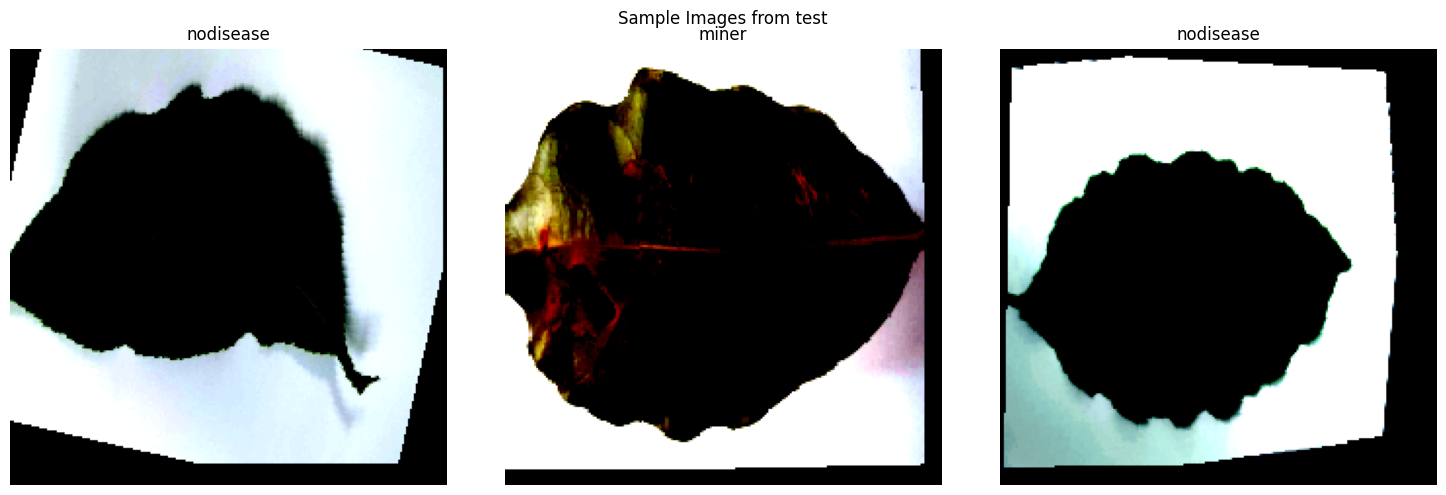


Dataset: train aug
Class Distribution:
Cerscospora: 2700
Healthy: 2700
Leaf rust: 2700
Phoma: 2700


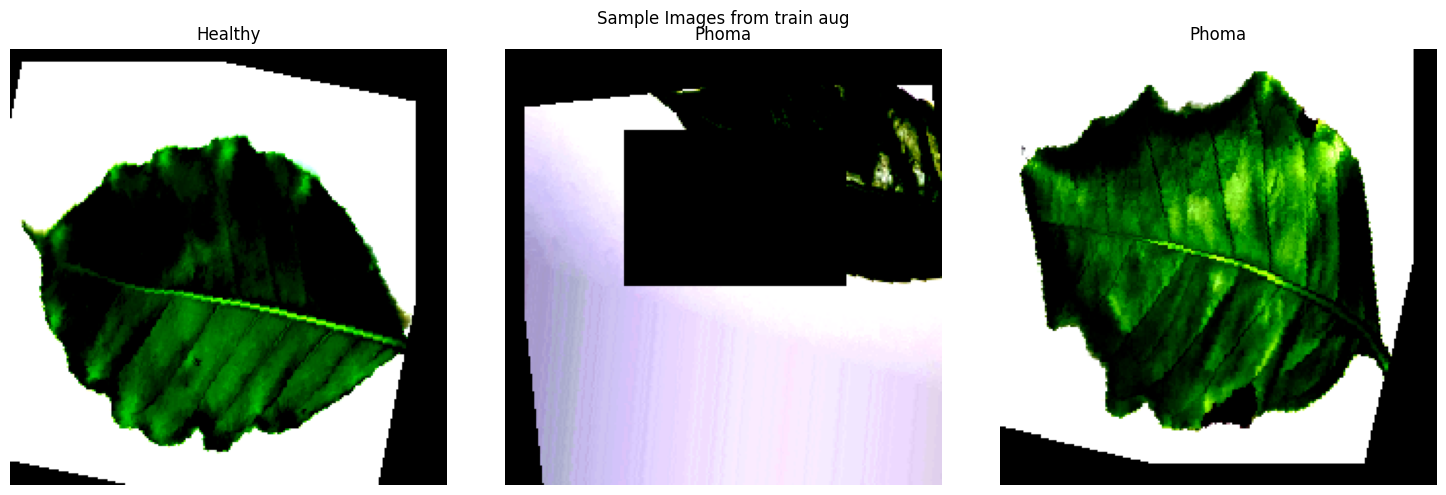


Dataset: test
Class Distribution:
Cerscospora: 300
Healthy: 300
Leaf rust: 300
Phoma: 300


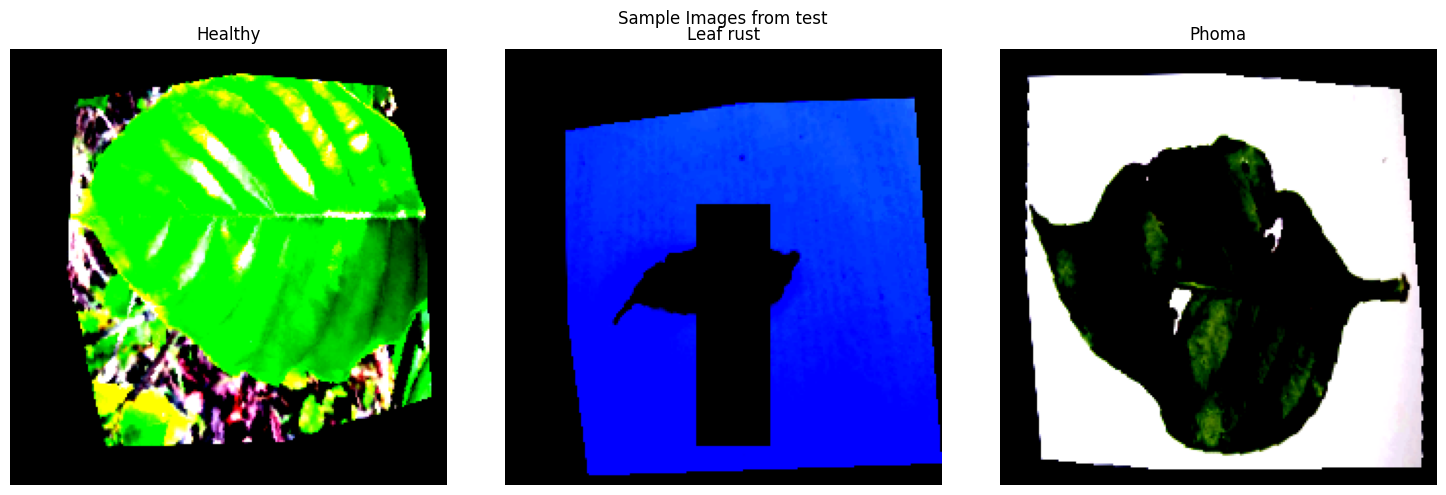


Dataset: JMuBEN
Class Distribution:
Cerscospora: 7681
Healthy: 18983
Leaf rust: 8336
Miner: 16978
Phoma: 6571


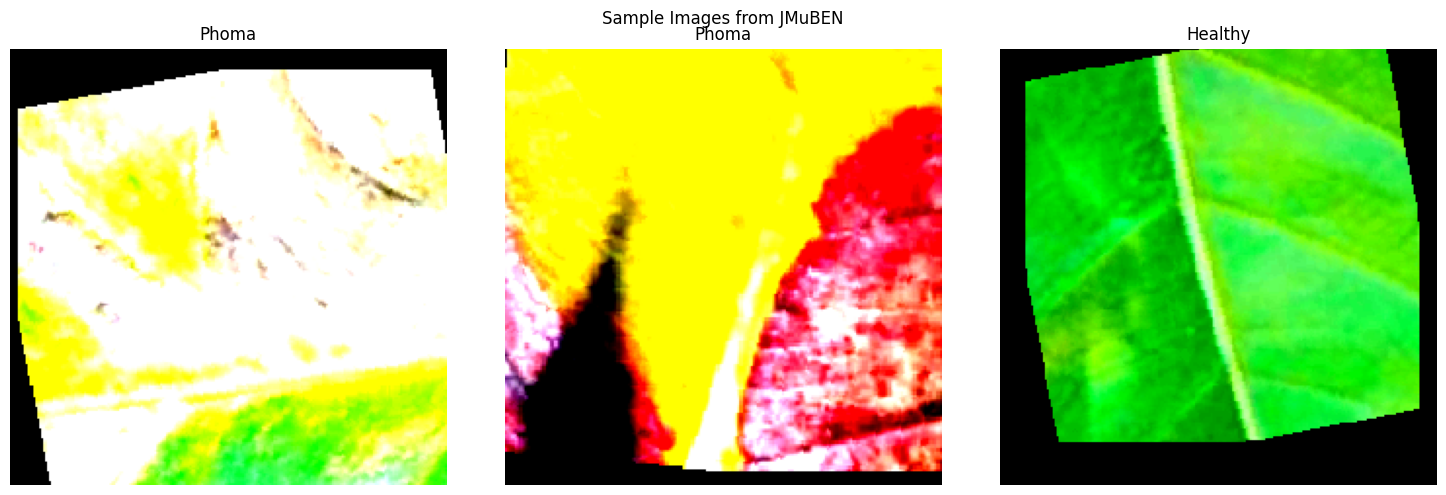


📊 Total classes found: 10
Classes: ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma', 'Rust', 'miner', 'nodisease', 'phoma', 'rust']
✅ Dataset loading completed!
Total samples: 72613
Number of classes: 10


In [6]:
# Data Loading Functions - Improved from Sprint 1
def load_datasets(paths, transform):
    """Load all datasets and combine them"""
    datasets_list = []
    for path in paths:
        if os.path.exists(path):
            ds = datasets.ImageFolder(path, transform=transform)
            datasets_list.append(ds)
            print(f"Loaded dataset from {path}: {len(ds)} samples")
    return ConcatDataset(datasets_list)

def print_class_distribution(dataset):
    """Print class distribution"""
    labels = [label for _, label in dataset]
    counter = Counter(labels)
    print("Class Distribution:")
    for i, count in counter.items():
        print(f"{dataset.classes[i]}: {count}")

def show_sample_images(dataset, name, num_samples=3):
    """Show sample images from dataset"""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]
    
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    for ax, idx in zip(axes, indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"{dataset.classes[label]}")
        ax.axis("off")
    plt.suptitle(f"Sample Images from {name}")
    plt.tight_layout()
    plt.show()

# Dataset paths (same as Sprint 1)
DATASET_PATHS = [
    os.path.join(mohammedzwaughfa_coffee_leaf_disease_dataset_path, "dataset/test"),
    os.path.join(gauravduttakiit_coffee_leaf_diseases_path, "train"),
    os.path.join(gauravduttakiit_coffee_leaf_diseases_path, "test"),
    os.path.join(biniyamyoseph_ethiopian_coffee_leaf_disease_path, "ethiopian cofee leaf dataset/train aug"),
    os.path.join(biniyamyoseph_ethiopian_coffee_leaf_disease_path, "ethiopian cofee leaf dataset/test"),
    os.path.join(noamaanabdulazeem_jmuben_coffee_dataset_path, "JMuBEN"),
]

# Load and display EDA
print("🔍 Loading and exploring datasets...")

# Use advanced transforms for training
train_transform = AdvancedTransforms.get_train_transforms(CONFIG['img_size'])
val_transform = AdvancedTransforms.get_val_transforms(CONFIG['img_size'])

# Load datasets
combined_dataset = load_datasets(DATASET_PATHS, train_transform)

# Show sample images from each dataset
for dpath in DATASET_PATHS:
    if os.path.exists(dpath):
        dname = dpath.split("/")[-1]
        ds = datasets.ImageFolder(dpath, transform=train_transform)
        print(f"\nDataset: {dname}")
        print_class_distribution(ds)
        show_sample_images(ds, dname)

# Define class names
class_names = sorted(list(set([cls for dset in combined_dataset.datasets for cls in dset.classes])))
print(f"\n📊 Total classes found: {len(class_names)}")
print(f"Classes: {class_names}")

# Update CONFIG with actual class names
CONFIG['class_names'] = class_names
CONFIG['num_classes'] = len(class_names)

print(f"✅ Dataset loading completed!")
print(f"Total samples: {len(combined_dataset)}")
print(f"Number of classes: {CONFIG['num_classes']}")


In [7]:
# Training and Evaluation Functions - Improved from Sprint 1
class EarlyStopping:
    """Early stopping utility to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        """Save model checkpoint"""
        self.best_weights = model.state_dict().copy()

class MetricsTracker:
    """Track training and validation metrics"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.learning_rates = []
        self.epochs = []
    
    def update(self, epoch, train_loss, val_loss, train_acc, val_acc, lr):
        self.epochs.append(epoch)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.train_accuracies.append(train_acc)
        self.val_accuracies.append(val_acc)
        self.learning_rates.append(lr)
    
    def get_best_epoch(self):
        """Get epoch with best validation accuracy"""
        best_idx = np.argmax(self.val_accuracies)
        return self.epochs[best_idx], self.val_accuracies[best_idx]

def train_and_evaluate_model(model, model_name, train_loader, val_loader, config):
    """Advanced training function with all improvements"""
    print(f"\n🔧 Training: {model_name}")
    
    # Initialize metrics tracker
    metrics = MetricsTracker()
    
    # Initialize early stopping
    early_stopping = EarlyStopping(
        patience=config['patience'],
        min_delta=config['min_delta']
    )
    
    # Loss function with label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
    
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    
    # Learning rate scheduler
    if config['scheduler_type'] == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'])
    elif config['scheduler_type'] == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    else:
        scheduler = StepLR(optimizer, step_size=15, gamma=0.1)
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler() if config['use_mixed_precision'] and torch.cuda.is_available() else None
    
    model.to(device)
    
    print(f"🚀 Starting training for {model_name}")
    print(f"Epochs: {config['num_epochs']}")
    print(f"Learning rate: {config['learning_rate']}")
    print(f"Scheduler: {config['scheduler_type']}")
    print(f"Mixed precision: {config['use_mixed_precision']}")
    print(f"Advanced augmentation: {config['use_advanced_augmentation']}")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(config['num_epochs']):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"{model_name} Epoch {epoch+1}")):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            
            # Apply Mixup or CutMix randomly
            if config['use_advanced_augmentation'] and np.random.random() < 0.5:
                if np.random.random() < 0.5:  # Mixup
                    data, target_a, target_b, lam = mixup_data(data, target, config['mixup_alpha'])
                    if scaler:
                        with torch.cuda.amp.autocast():
                            output = model(data)
                            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
                    else:
                        output = model(data)
                        loss = mixup_criterion(criterion, output, target_a, target_b, lam)
                else:  # CutMix
                    data, target_a, target_b, lam = cutmix_data(data, target, config['cutmix_alpha'])
                    if scaler:
                        with torch.cuda.amp.autocast():
                            output = model(data)
                            loss = mixup_criterion(criterion, output, target_a, target_b, lam)
                    else:
                        output = model(data)
                        loss = mixup_criterion(criterion, output, target_a, target_b, lam)
            else:
                if scaler:
                    with torch.cuda.amp.autocast():
                        output = model(data)
                        loss = criterion(output, target)
                else:
                    output = model(data)
                    loss = criterion(output, target)
            
            # Backward pass
            if scaler:
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip_norm'])
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip_norm'])
                optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update metrics
        metrics.update(epoch, train_loss, val_loss, train_acc, val_acc, current_lr)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{config["num_epochs"]}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')
        
        # Learning rate scheduling
        if config['scheduler_type'] == 'plateau':
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        # Early stopping check
        if early_stopping(val_loss, model):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        print("-" * 60)
    
    training_time = time.time() - start_time
    best_epoch, best_val_acc = metrics.get_best_epoch()
    
    print(f"✅ Training completed!")
    print(f"Total training time: {training_time/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch+1}")
    
    return model, metrics

print("Training functions loaded successfully!")


Training functions loaded successfully!


In [8]:
# Visualization Functions
def plot_training_curves(metrics, model_name, save_path=None):
    """Plot comprehensive training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{model_name} - Training Progress', fontsize=16, fontweight='bold')
    
    # Loss curves
    axes[0, 0].plot(metrics.epochs, metrics.train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(metrics.epochs, metrics.val_losses, 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[0, 1].plot(metrics.epochs, metrics.train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(metrics.epochs, metrics.val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Accuracy Curves')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Learning rate curve
    axes[1, 0].plot(metrics.epochs, metrics.learning_rates, 'g-', linewidth=2)
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Validation accuracy distribution
    axes[1, 1].hist(metrics.val_accuracies, bins=20, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(np.max(metrics.val_accuracies), color='red', linestyle='--', 
                      label=f'Best: {np.max(metrics.val_accuracies):.2f}%')
    axes[1, 1].set_title('Validation Accuracy Distribution')
    axes[1, 1].set_xlabel('Accuracy (%)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training curves saved to {save_path}")
    
    plt.show()

def plot_model_comparison(all_metrics, save_path=None):
    """Plot comparison between different models"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Sprint 4 - Model Comparison (Trained from Scratch)', fontsize=16, fontweight='bold')
    
    # Best validation accuracy comparison
    model_names = list(all_metrics.keys())
    best_accuracies = [np.max(metrics.val_accuracies) for metrics in all_metrics.values()]
    
    bars = axes[0].bar(model_names, best_accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0].set_title('Best Validation Accuracy')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, acc in zip(bars, best_accuracies):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    axes[0].grid(True, alpha=0.3)
    
    # Training curves overlay
    for model_name, metrics in all_metrics.items():
        axes[1].plot(metrics.epochs, metrics.val_accuracies, label=model_name, linewidth=2)
    
    axes[1].set_title('Validation Accuracy Over Time')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Model comparison saved to {save_path}")
    
    plt.show()

def plot_confusion_matrix(model, data_loader, class_names, model_name, save_path=None):
    """Plot confusion matrix for model evaluation"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to {save_path}")
    
    plt.show()
    
    # Print classification report
    print(f"\n{classification_report(all_targets, all_preds, target_names=class_names)}")

print("Visualization functions loaded successfully!")


Visualization functions loaded successfully!


In [9]:
# Main Training Pipeline - Improved from Sprint 1
print("🚀 Starting Sprint 4 Training Pipeline - Custom CNNs from Scratch")
print("=" * 80)

# Create save directory
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# Use a subset for faster training (same as Sprint 1)
subset_size = int(len(combined_dataset) * CONFIG['subset_fraction'])
combined_dataset, _ = random_split(combined_dataset, [subset_size, len(combined_dataset) - subset_size])

# Split dataset
train_size = int(0.7 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
print(f"Training size: {train_size}, Validation size: {val_size}")

train_data, val_data = random_split(combined_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=4)

print(f"✅ Data loaders created successfully!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Define custom models
models_dict = {
    "CustomCNN1": CustomCNN1(num_classes=CONFIG['num_classes']),
    "CustomCNN2": CustomCNN2(num_classes=CONFIG['num_classes']),
    "CustomCNN3": CustomCNN3(num_classes=CONFIG['num_classes']),
}

# Print model information
print("\n📊 Model Information:")
for name, model in models_dict.items():
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name}: {total_params:,} total parameters, {trainable_params:,} trainable")

print("\n" + "=" * 80)
print("🎯 Starting training of custom CNN models...")
print("=" * 80)


🚀 Starting Sprint 4 Training Pipeline - Custom CNNs from Scratch
Training size: 40663, Validation size: 17427
✅ Data loaders created successfully!
Training batches: 1271
Validation batches: 545

📊 Model Information:
CustomCNN1: 1,208,362 total parameters, 1,208,362 trainable
CustomCNN2: 11,342,090 total parameters, 11,342,090 trainable
CustomCNN3: 1,395,050 total parameters, 1,395,050 trainable

🎯 Starting training of custom CNN models...



🔄 Training CustomCNN1...
--------------------------------------------------

🔧 Training: CustomCNN1
🚀 Starting training for CustomCNN1
Epochs: 50
Learning rate: 0.001
Scheduler: cosine
Mixed precision: True
Advanced augmentation: True
------------------------------------------------------------


CustomCNN1 Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:04<00:00, 19.56it/s]


Epoch 1/50:
  Train Loss: 1.2864, Train Acc: 59.75%
  Val Loss: 0.9859, Val Acc: 78.42%
  Learning Rate: 0.001000
------------------------------------------------------------


CustomCNN1 Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.42it/s]


Epoch 2/50:
  Train Loss: 1.1128, Train Acc: 68.34%
  Val Loss: 0.8555, Val Acc: 82.98%
  Learning Rate: 0.000999
------------------------------------------------------------


CustomCNN1 Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.19it/s]


Epoch 3/50:
  Train Loss: 1.0409, Train Acc: 70.81%
  Val Loss: 0.7939, Val Acc: 86.47%
  Learning Rate: 0.000996
------------------------------------------------------------


CustomCNN1 Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.31it/s]


Epoch 4/50:
  Train Loss: 0.9905, Train Acc: 73.29%
  Val Loss: 0.7620, Val Acc: 88.68%
  Learning Rate: 0.000991
------------------------------------------------------------


CustomCNN1 Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.28it/s]


Epoch 5/50:
  Train Loss: 0.9678, Train Acc: 74.86%
  Val Loss: 0.7187, Val Acc: 91.01%
  Learning Rate: 0.000984
------------------------------------------------------------


CustomCNN1 Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.28it/s]


Epoch 6/50:
  Train Loss: 0.9512, Train Acc: 74.91%
  Val Loss: 0.7069, Val Acc: 90.82%
  Learning Rate: 0.000976
------------------------------------------------------------


CustomCNN1 Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.23it/s]


Epoch 7/50:
  Train Loss: 0.9262, Train Acc: 75.95%
  Val Loss: 0.7154, Val Acc: 90.61%
  Learning Rate: 0.000965
------------------------------------------------------------


CustomCNN1 Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.25it/s]


Epoch 8/50:
  Train Loss: 0.8882, Train Acc: 78.03%
  Val Loss: 0.6725, Val Acc: 92.58%
  Learning Rate: 0.000952
------------------------------------------------------------


CustomCNN1 Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.33it/s]


Epoch 9/50:
  Train Loss: 0.8864, Train Acc: 77.51%
  Val Loss: 0.6554, Val Acc: 93.23%
  Learning Rate: 0.000938
------------------------------------------------------------


CustomCNN1 Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.25it/s]


Epoch 10/50:
  Train Loss: 0.8689, Train Acc: 77.74%
  Val Loss: 0.6558, Val Acc: 93.21%
  Learning Rate: 0.000922
------------------------------------------------------------


CustomCNN1 Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.19it/s]


Epoch 11/50:
  Train Loss: 0.8442, Train Acc: 78.66%
  Val Loss: 0.6335, Val Acc: 93.88%
  Learning Rate: 0.000905
------------------------------------------------------------


CustomCNN1 Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.25it/s]


Epoch 12/50:
  Train Loss: 0.8437, Train Acc: 79.65%
  Val Loss: 0.6252, Val Acc: 94.74%
  Learning Rate: 0.000885
------------------------------------------------------------


CustomCNN1 Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.22it/s]


Epoch 13/50:
  Train Loss: 0.8226, Train Acc: 79.87%
  Val Loss: 0.6171, Val Acc: 94.77%
  Learning Rate: 0.000864
------------------------------------------------------------


CustomCNN1 Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.24it/s]


Epoch 14/50:
  Train Loss: 0.8248, Train Acc: 80.52%
  Val Loss: 0.6203, Val Acc: 94.76%
  Learning Rate: 0.000842
------------------------------------------------------------


CustomCNN1 Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.28it/s]


Epoch 15/50:
  Train Loss: 0.8142, Train Acc: 80.34%
  Val Loss: 0.6004, Val Acc: 95.74%
  Learning Rate: 0.000819
------------------------------------------------------------


CustomCNN1 Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.17it/s]


Epoch 16/50:
  Train Loss: 0.8003, Train Acc: 80.71%
  Val Loss: 0.5946, Val Acc: 95.67%
  Learning Rate: 0.000794
------------------------------------------------------------


CustomCNN1 Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.28it/s]


Epoch 17/50:
  Train Loss: 0.8020, Train Acc: 79.63%
  Val Loss: 0.5988, Val Acc: 95.94%
  Learning Rate: 0.000768
------------------------------------------------------------


CustomCNN1 Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.29it/s]


Epoch 18/50:
  Train Loss: 0.7908, Train Acc: 79.57%
  Val Loss: 0.5823, Val Acc: 96.57%
  Learning Rate: 0.000741
------------------------------------------------------------


CustomCNN1 Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.29it/s]


Epoch 19/50:
  Train Loss: 0.7808, Train Acc: 81.30%
  Val Loss: 0.5753, Val Acc: 96.80%
  Learning Rate: 0.000713
------------------------------------------------------------


CustomCNN1 Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.19it/s]


Epoch 20/50:
  Train Loss: 0.7647, Train Acc: 81.45%
  Val Loss: 0.5808, Val Acc: 96.39%
  Learning Rate: 0.000684
------------------------------------------------------------


CustomCNN1 Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.13it/s]


Epoch 21/50:
  Train Loss: 0.7577, Train Acc: 81.98%
  Val Loss: 0.5780, Val Acc: 96.37%
  Learning Rate: 0.000655
------------------------------------------------------------


CustomCNN1 Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.19it/s]


Epoch 22/50:
  Train Loss: 0.7612, Train Acc: 82.06%
  Val Loss: 0.5694, Val Acc: 97.25%
  Learning Rate: 0.000624
------------------------------------------------------------


CustomCNN1 Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.31it/s]


Epoch 23/50:
  Train Loss: 0.7487, Train Acc: 82.29%
  Val Loss: 0.5749, Val Acc: 96.86%
  Learning Rate: 0.000594
------------------------------------------------------------


CustomCNN1 Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.21it/s]


Epoch 24/50:
  Train Loss: 0.7604, Train Acc: 82.54%
  Val Loss: 0.5707, Val Acc: 96.98%
  Learning Rate: 0.000563
------------------------------------------------------------


CustomCNN1 Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.21it/s]


Epoch 25/50:
  Train Loss: 0.7529, Train Acc: 82.80%
  Val Loss: 0.5609, Val Acc: 97.31%
  Learning Rate: 0.000531
------------------------------------------------------------


CustomCNN1 Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.45it/s]


Epoch 26/50:
  Train Loss: 0.7371, Train Acc: 83.32%
  Val Loss: 0.5634, Val Acc: 97.53%
  Learning Rate: 0.000500
------------------------------------------------------------


CustomCNN1 Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.19it/s]


Epoch 27/50:
  Train Loss: 0.7467, Train Acc: 81.73%
  Val Loss: 0.5624, Val Acc: 97.41%
  Learning Rate: 0.000469
------------------------------------------------------------


CustomCNN1 Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.30it/s]


Epoch 28/50:
  Train Loss: 0.7462, Train Acc: 82.54%
  Val Loss: 0.5616, Val Acc: 97.32%
  Learning Rate: 0.000437
------------------------------------------------------------


CustomCNN1 Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.27it/s]


Epoch 29/50:
  Train Loss: 0.7403, Train Acc: 82.33%
  Val Loss: 0.5601, Val Acc: 97.25%
  Learning Rate: 0.000406
------------------------------------------------------------


CustomCNN1 Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.26it/s]


Epoch 30/50:
  Train Loss: 0.7308, Train Acc: 83.36%
  Val Loss: 0.5590, Val Acc: 97.60%
  Learning Rate: 0.000376
------------------------------------------------------------


CustomCNN1 Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.36it/s]


Epoch 31/50:
  Train Loss: 0.7278, Train Acc: 83.57%
  Val Loss: 0.5567, Val Acc: 97.53%
  Learning Rate: 0.000345
------------------------------------------------------------


CustomCNN1 Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.23it/s]


Epoch 32/50:
  Train Loss: 0.7344, Train Acc: 82.60%
  Val Loss: 0.5539, Val Acc: 97.48%
  Learning Rate: 0.000316
------------------------------------------------------------


CustomCNN1 Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.26it/s]


Epoch 33/50:
  Train Loss: 0.7206, Train Acc: 83.31%
  Val Loss: 0.5514, Val Acc: 97.67%
  Learning Rate: 0.000287
------------------------------------------------------------


CustomCNN1 Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.25it/s]


Epoch 34/50:
  Train Loss: 0.7253, Train Acc: 83.45%
  Val Loss: 0.5520, Val Acc: 97.81%
  Learning Rate: 0.000259
------------------------------------------------------------


CustomCNN1 Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.20it/s]


Epoch 35/50:
  Train Loss: 0.7316, Train Acc: 83.05%
  Val Loss: 0.5512, Val Acc: 97.53%
  Learning Rate: 0.000232
------------------------------------------------------------


CustomCNN1 Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.21it/s]


Epoch 36/50:
  Train Loss: 0.7298, Train Acc: 81.26%
  Val Loss: 0.5506, Val Acc: 97.71%
  Learning Rate: 0.000206
------------------------------------------------------------


CustomCNN1 Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.24it/s]


Epoch 37/50:
  Train Loss: 0.7190, Train Acc: 84.26%
  Val Loss: 0.5498, Val Acc: 97.79%
  Learning Rate: 0.000181
------------------------------------------------------------


CustomCNN1 Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.26it/s]


Epoch 38/50:
  Train Loss: 0.7225, Train Acc: 83.44%
  Val Loss: 0.5494, Val Acc: 97.81%
  Learning Rate: 0.000158
------------------------------------------------------------


CustomCNN1 Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.27it/s]


Epoch 39/50:
  Train Loss: 0.7340, Train Acc: 81.44%
  Val Loss: 0.5489, Val Acc: 97.76%
  Learning Rate: 0.000136
------------------------------------------------------------


CustomCNN1 Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.29it/s]


Epoch 40/50:
  Train Loss: 0.7225, Train Acc: 83.01%
  Val Loss: 0.5491, Val Acc: 97.75%
  Learning Rate: 0.000115
------------------------------------------------------------


CustomCNN1 Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.27it/s]


Epoch 41/50:
  Train Loss: 0.7122, Train Acc: 84.17%
  Val Loss: 0.5483, Val Acc: 97.84%
  Learning Rate: 0.000095
------------------------------------------------------------


CustomCNN1 Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.25it/s]


Epoch 42/50:
  Train Loss: 0.7180, Train Acc: 81.98%
  Val Loss: 0.5473, Val Acc: 97.76%
  Learning Rate: 0.000078
------------------------------------------------------------


CustomCNN1 Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.25it/s]


Epoch 43/50:
  Train Loss: 0.7147, Train Acc: 82.88%
  Val Loss: 0.5469, Val Acc: 97.83%
  Learning Rate: 0.000062
------------------------------------------------------------


CustomCNN1 Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.28it/s]


Epoch 44/50:
  Train Loss: 0.7178, Train Acc: 83.36%
  Val Loss: 0.5477, Val Acc: 97.84%
  Learning Rate: 0.000048
------------------------------------------------------------


CustomCNN1 Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.17it/s]


Epoch 45/50:
  Train Loss: 0.7287, Train Acc: 83.30%
  Val Loss: 0.5456, Val Acc: 97.95%
  Learning Rate: 0.000035
------------------------------------------------------------


CustomCNN1 Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.26it/s]


Epoch 46/50:
  Train Loss: 0.7144, Train Acc: 84.08%
  Val Loss: 0.5490, Val Acc: 97.79%
  Learning Rate: 0.000024
------------------------------------------------------------


CustomCNN1 Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.24it/s]


Epoch 47/50:
  Train Loss: 0.7234, Train Acc: 84.48%
  Val Loss: 0.5459, Val Acc: 97.81%
  Learning Rate: 0.000016
------------------------------------------------------------


CustomCNN1 Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.25it/s]


Epoch 48/50:
  Train Loss: 0.7119, Train Acc: 84.65%
  Val Loss: 0.5460, Val Acc: 97.79%
  Learning Rate: 0.000009
------------------------------------------------------------


CustomCNN1 Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:05<00:00, 19.27it/s]


Epoch 49/50:
  Train Loss: 0.7101, Train Acc: 83.62%
  Val Loss: 0.5457, Val Acc: 97.87%
  Learning Rate: 0.000004
------------------------------------------------------------


CustomCNN1 Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [01:06<00:00, 19.14it/s]


Epoch 50/50:
  Train Loss: 0.7041, Train Acc: 84.01%
  Val Loss: 0.5468, Val Acc: 97.79%
  Learning Rate: 0.000001
------------------------------------------------------------
✅ Training completed!
Total training time: 72.23 minutes
Best validation accuracy: 97.95% at epoch 45
✅ CustomCNN1 saved to ./modelos/sprint-4/CustomCNN1_best.pth
Training curves saved to ./modelos/sprint-4/CustomCNN1_training_curves.png


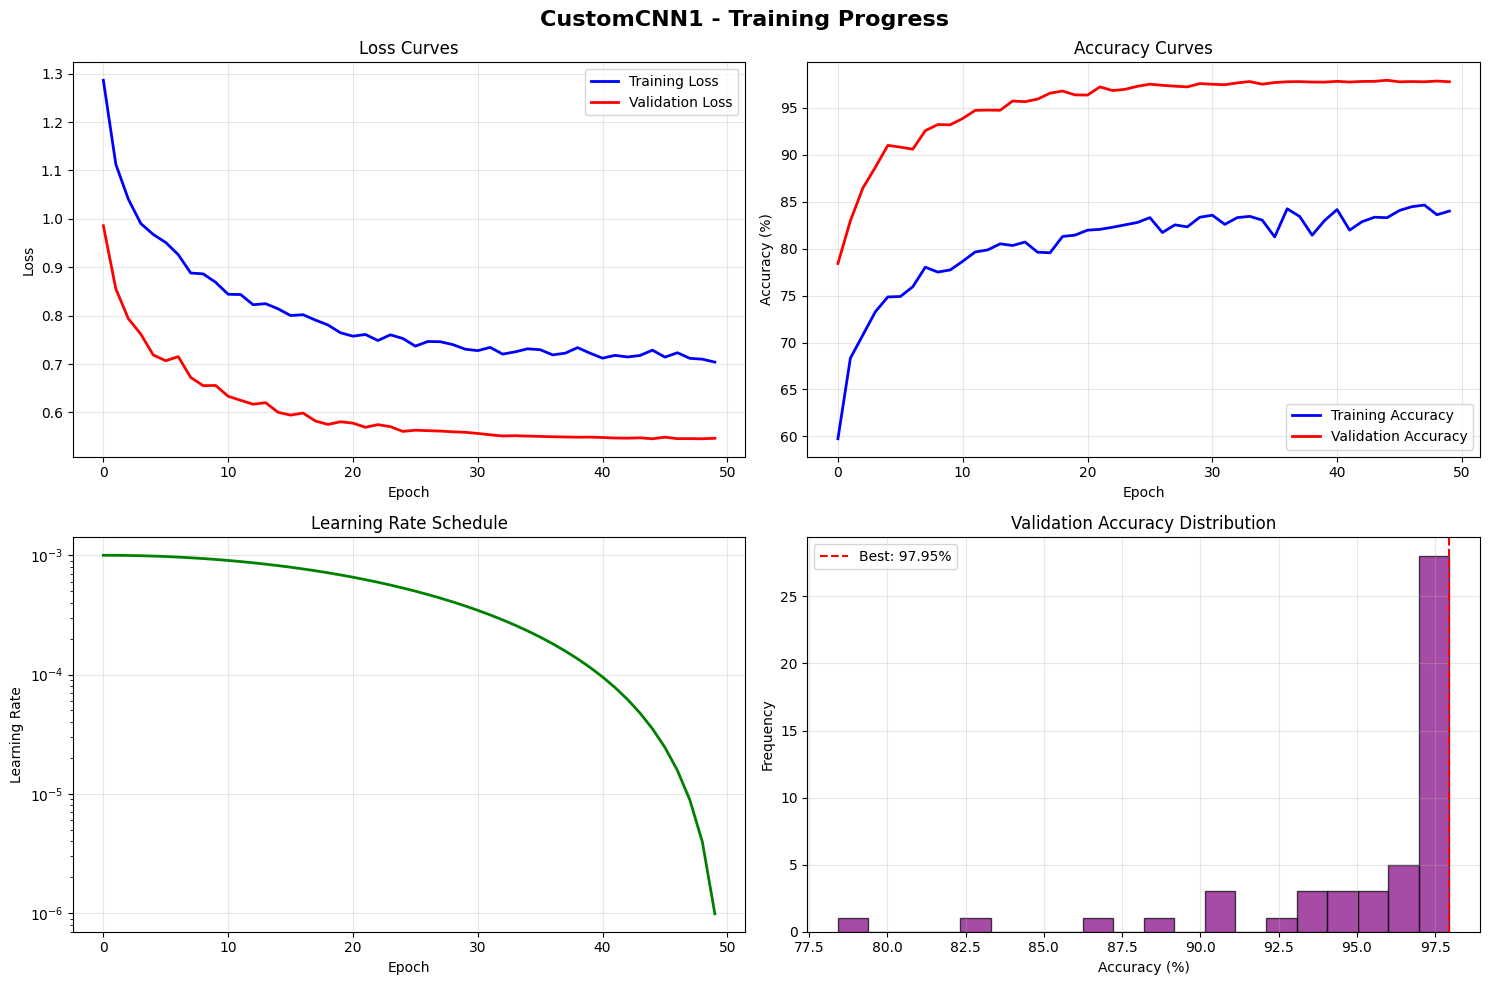

Confusion matrix saved to ./modelos/sprint-4/CustomCNN1_confusion_matrix.png


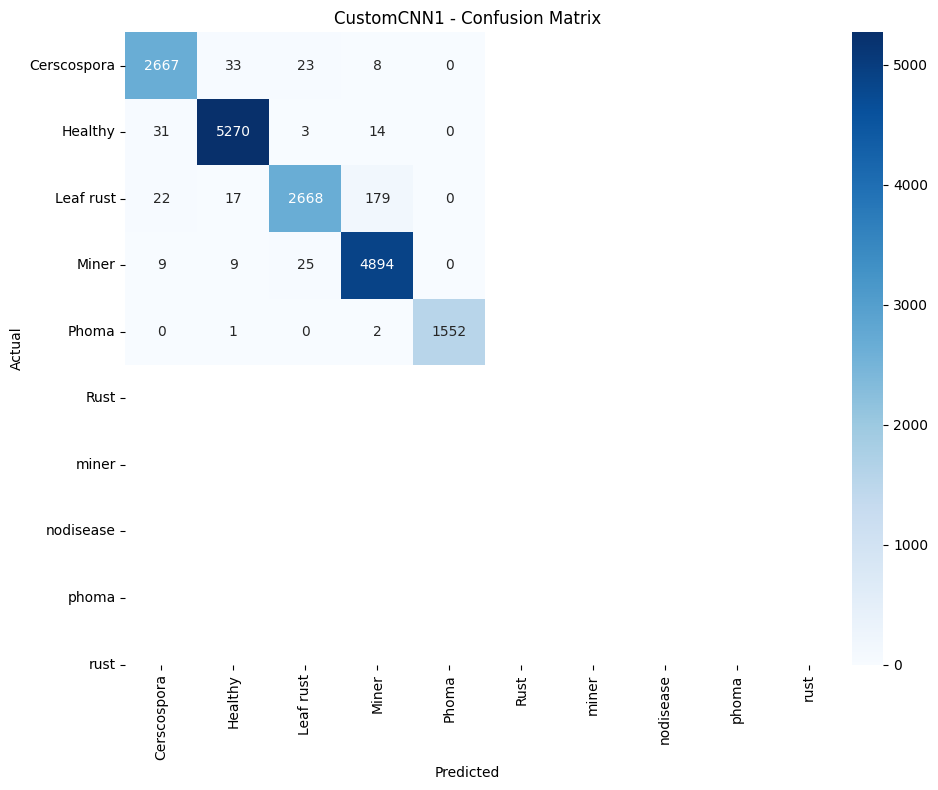

❌ Error training CustomCNN1: Number of classes, 5, does not match size of target_names, 10. Try specifying the labels parameter

🔄 Training CustomCNN2...
--------------------------------------------------

🔧 Training: CustomCNN2
🚀 Starting training for CustomCNN2
Epochs: 50
Learning rate: 0.001
Scheduler: cosine
Mixed precision: True
Advanced augmentation: True
------------------------------------------------------------


CustomCNN2 Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.87it/s]


Epoch 1/50:
  Train Loss: 1.3465, Train Acc: 57.54%
  Val Loss: 1.1187, Val Acc: 73.92%
  Learning Rate: 0.001000
------------------------------------------------------------


CustomCNN2 Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.30it/s]


Epoch 2/50:
  Train Loss: 1.1317, Train Acc: 66.64%
  Val Loss: 0.9262, Val Acc: 79.82%
  Learning Rate: 0.000999
------------------------------------------------------------


CustomCNN2 Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.68it/s]


Epoch 3/50:
  Train Loss: 1.0469, Train Acc: 71.22%
  Val Loss: 0.7572, Val Acc: 87.71%
  Learning Rate: 0.000996
------------------------------------------------------------


CustomCNN2 Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.65it/s]


Epoch 4/50:
  Train Loss: 0.9864, Train Acc: 73.32%
  Val Loss: 0.7464, Val Acc: 90.12%
  Learning Rate: 0.000991
------------------------------------------------------------


CustomCNN2 Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.38it/s]


Epoch 5/50:
  Train Loss: 0.9275, Train Acc: 76.09%
  Val Loss: 0.6920, Val Acc: 91.03%
  Learning Rate: 0.000984
------------------------------------------------------------


CustomCNN2 Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.20it/s]


Epoch 6/50:
  Train Loss: 0.9308, Train Acc: 75.67%
  Val Loss: 0.7063, Val Acc: 91.03%
  Learning Rate: 0.000976
------------------------------------------------------------


CustomCNN2 Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.22it/s]


Epoch 7/50:
  Train Loss: 0.9100, Train Acc: 76.95%
  Val Loss: 0.6563, Val Acc: 93.13%
  Learning Rate: 0.000965
------------------------------------------------------------


CustomCNN2 Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.58it/s]


Epoch 8/50:
  Train Loss: 0.8919, Train Acc: 77.28%
  Val Loss: 0.6965, Val Acc: 91.30%
  Learning Rate: 0.000952
------------------------------------------------------------


CustomCNN2 Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.89it/s]


Epoch 9/50:
  Train Loss: 0.8631, Train Acc: 77.24%
  Val Loss: 0.6613, Val Acc: 93.04%
  Learning Rate: 0.000938
------------------------------------------------------------


CustomCNN2 Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.53it/s]


Epoch 10/50:
  Train Loss: 0.8646, Train Acc: 78.64%
  Val Loss: 0.6521, Val Acc: 93.64%
  Learning Rate: 0.000922
------------------------------------------------------------


CustomCNN2 Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.31it/s]


Epoch 11/50:
  Train Loss: 0.8596, Train Acc: 77.27%
  Val Loss: 0.6628, Val Acc: 93.31%
  Learning Rate: 0.000905
------------------------------------------------------------


CustomCNN2 Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.36it/s]


Epoch 12/50:
  Train Loss: 0.8343, Train Acc: 78.91%
  Val Loss: 0.6471, Val Acc: 93.37%
  Learning Rate: 0.000885
------------------------------------------------------------


CustomCNN2 Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.59it/s]


Epoch 13/50:
  Train Loss: 0.8278, Train Acc: 79.52%
  Val Loss: 0.6183, Val Acc: 94.51%
  Learning Rate: 0.000864
------------------------------------------------------------


CustomCNN2 Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.23it/s]


Epoch 14/50:
  Train Loss: 0.8235, Train Acc: 79.53%
  Val Loss: 0.6143, Val Acc: 94.92%
  Learning Rate: 0.000842
------------------------------------------------------------


CustomCNN2 Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.48it/s]


Epoch 15/50:
  Train Loss: 0.8218, Train Acc: 80.38%
  Val Loss: 0.6189, Val Acc: 95.15%
  Learning Rate: 0.000819
------------------------------------------------------------


CustomCNN2 Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.63it/s]


Epoch 16/50:
  Train Loss: 0.8147, Train Acc: 79.85%
  Val Loss: 0.6329, Val Acc: 93.87%
  Learning Rate: 0.000794
------------------------------------------------------------


CustomCNN2 Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.70it/s]


Epoch 17/50:
  Train Loss: 0.8187, Train Acc: 79.85%
  Val Loss: 0.6206, Val Acc: 94.64%
  Learning Rate: 0.000768
------------------------------------------------------------


CustomCNN2 Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.37it/s]


Epoch 18/50:
  Train Loss: 0.7892, Train Acc: 81.44%
  Val Loss: 0.6095, Val Acc: 95.51%
  Learning Rate: 0.000741
------------------------------------------------------------


CustomCNN2 Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.43it/s]


Epoch 19/50:
  Train Loss: 0.8027, Train Acc: 80.34%
  Val Loss: 0.5942, Val Acc: 95.57%
  Learning Rate: 0.000713
------------------------------------------------------------


CustomCNN2 Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.15it/s]


Epoch 20/50:
  Train Loss: 0.7887, Train Acc: 81.13%
  Val Loss: 0.5890, Val Acc: 95.88%
  Learning Rate: 0.000684
------------------------------------------------------------


CustomCNN2 Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.47it/s]


Epoch 21/50:
  Train Loss: 0.7756, Train Acc: 82.02%
  Val Loss: 0.5901, Val Acc: 95.85%
  Learning Rate: 0.000655
------------------------------------------------------------


CustomCNN2 Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.20it/s]


Epoch 22/50:
  Train Loss: 0.7760, Train Acc: 81.32%
  Val Loss: 0.5860, Val Acc: 96.23%
  Learning Rate: 0.000624
------------------------------------------------------------


CustomCNN2 Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.52it/s]


Epoch 23/50:
  Train Loss: 0.7735, Train Acc: 81.81%
  Val Loss: 0.5866, Val Acc: 96.65%
  Learning Rate: 0.000594
------------------------------------------------------------


CustomCNN2 Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.71it/s]


Epoch 24/50:
  Train Loss: 0.7617, Train Acc: 81.26%
  Val Loss: 0.5878, Val Acc: 96.60%
  Learning Rate: 0.000563
------------------------------------------------------------


CustomCNN2 Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.37it/s]


Epoch 25/50:
  Train Loss: 0.7664, Train Acc: 81.83%
  Val Loss: 0.5856, Val Acc: 96.54%
  Learning Rate: 0.000531
------------------------------------------------------------


CustomCNN2 Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.35it/s]


Epoch 26/50:
  Train Loss: 0.7573, Train Acc: 81.86%
  Val Loss: 0.5739, Val Acc: 96.63%
  Learning Rate: 0.000500
------------------------------------------------------------


CustomCNN2 Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.53it/s]


Epoch 27/50:
  Train Loss: 0.7429, Train Acc: 82.87%
  Val Loss: 0.5716, Val Acc: 96.84%
  Learning Rate: 0.000469
------------------------------------------------------------


CustomCNN2 Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.42it/s]


Epoch 28/50:
  Train Loss: 0.7474, Train Acc: 82.76%
  Val Loss: 0.5739, Val Acc: 96.95%
  Learning Rate: 0.000437
------------------------------------------------------------


CustomCNN2 Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.46it/s]


Epoch 29/50:
  Train Loss: 0.7394, Train Acc: 82.64%
  Val Loss: 0.5683, Val Acc: 96.93%
  Learning Rate: 0.000406
------------------------------------------------------------


CustomCNN2 Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.40it/s]


Epoch 30/50:
  Train Loss: 0.7425, Train Acc: 81.71%
  Val Loss: 0.5592, Val Acc: 97.21%
  Learning Rate: 0.000376
------------------------------------------------------------


CustomCNN2 Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.58it/s]


Epoch 31/50:
  Train Loss: 0.7303, Train Acc: 83.49%
  Val Loss: 0.5777, Val Acc: 97.29%
  Learning Rate: 0.000345
------------------------------------------------------------


CustomCNN2 Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.54it/s]


Epoch 32/50:
  Train Loss: 0.7320, Train Acc: 82.86%
  Val Loss: 0.5589, Val Acc: 97.25%
  Learning Rate: 0.000316
------------------------------------------------------------


CustomCNN2 Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.55it/s]


Epoch 33/50:
  Train Loss: 0.7288, Train Acc: 82.05%
  Val Loss: 0.5565, Val Acc: 97.44%
  Learning Rate: 0.000287
------------------------------------------------------------


CustomCNN2 Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.26it/s]


Epoch 34/50:
  Train Loss: 0.7249, Train Acc: 84.69%
  Val Loss: 0.5657, Val Acc: 97.35%
  Learning Rate: 0.000259
------------------------------------------------------------


CustomCNN2 Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:51<00:00, 24.53it/s]


Epoch 35/50:
  Train Loss: 0.7452, Train Acc: 82.65%
  Val Loss: 0.5546, Val Acc: 97.50%
  Learning Rate: 0.000232
------------------------------------------------------------


CustomCNN2 Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:52<00:00, 24.35it/s]


Epoch 36/50:
  Train Loss: 0.7159, Train Acc: 83.31%
  Val Loss: 0.5582, Val Acc: 97.68%
  Learning Rate: 0.000206
------------------------------------------------------------


CustomCNN2 Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.57it/s]


Epoch 37/50:
  Train Loss: 0.7272, Train Acc: 83.52%
  Val Loss: 0.5553, Val Acc: 97.69%
  Learning Rate: 0.000181
------------------------------------------------------------


CustomCNN2 Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.32it/s]


Epoch 38/50:
  Train Loss: 0.7167, Train Acc: 82.70%
  Val Loss: 0.5538, Val Acc: 97.56%
  Learning Rate: 0.000158
------------------------------------------------------------


CustomCNN2 Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:51<00:00, 24.91it/s]


Epoch 39/50:
  Train Loss: 0.7210, Train Acc: 83.47%
  Val Loss: 0.5565, Val Acc: 97.83%
  Learning Rate: 0.000136
------------------------------------------------------------


CustomCNN2 Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.28it/s]


Epoch 40/50:
  Train Loss: 0.7163, Train Acc: 83.31%
  Val Loss: 0.5530, Val Acc: 97.77%
  Learning Rate: 0.000115
------------------------------------------------------------


CustomCNN2 Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.43it/s]


Epoch 41/50:
  Train Loss: 0.7197, Train Acc: 84.19%
  Val Loss: 0.5509, Val Acc: 97.70%
  Learning Rate: 0.000095
------------------------------------------------------------


CustomCNN2 Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.33it/s]


Epoch 42/50:
  Train Loss: 0.7291, Train Acc: 83.27%
  Val Loss: 0.5509, Val Acc: 97.69%
  Learning Rate: 0.000078
------------------------------------------------------------


CustomCNN2 Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:53<00:00, 23.85it/s]


Epoch 43/50:
  Train Loss: 0.7078, Train Acc: 83.21%
  Val Loss: 0.5467, Val Acc: 97.77%
  Learning Rate: 0.000062
------------------------------------------------------------


CustomCNN2 Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.57it/s]


Epoch 44/50:
  Train Loss: 0.7157, Train Acc: 84.34%
  Val Loss: 0.5519, Val Acc: 97.84%
  Learning Rate: 0.000048
------------------------------------------------------------


CustomCNN2 Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.34it/s]


Epoch 45/50:
  Train Loss: 0.7168, Train Acc: 82.68%
  Val Loss: 0.5485, Val Acc: 97.80%
  Learning Rate: 0.000035
------------------------------------------------------------


CustomCNN2 Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.11it/s]


Epoch 46/50:
  Train Loss: 0.7074, Train Acc: 84.17%
  Val Loss: 0.5429, Val Acc: 97.88%
  Learning Rate: 0.000024
------------------------------------------------------------


CustomCNN2 Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.23it/s]


Epoch 47/50:
  Train Loss: 0.7034, Train Acc: 84.92%
  Val Loss: 0.5485, Val Acc: 97.80%
  Learning Rate: 0.000016
------------------------------------------------------------


CustomCNN2 Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.17it/s]


Epoch 48/50:
  Train Loss: 0.7107, Train Acc: 84.46%
  Val Loss: 0.5484, Val Acc: 97.80%
  Learning Rate: 0.000009
------------------------------------------------------------


CustomCNN2 Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:51<00:00, 24.66it/s]


Epoch 49/50:
  Train Loss: 0.6993, Train Acc: 84.44%
  Val Loss: 0.5459, Val Acc: 97.84%
  Learning Rate: 0.000004
------------------------------------------------------------


CustomCNN2 Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:51<00:00, 24.55it/s]


Epoch 50/50:
  Train Loss: 0.7112, Train Acc: 83.92%
  Val Loss: 0.5451, Val Acc: 97.78%
  Learning Rate: 0.000001
------------------------------------------------------------
✅ Training completed!
Total training time: 58.84 minutes
Best validation accuracy: 97.88% at epoch 46
✅ CustomCNN2 saved to ./modelos/sprint-4/CustomCNN2_best.pth
Training curves saved to ./modelos/sprint-4/CustomCNN2_training_curves.png


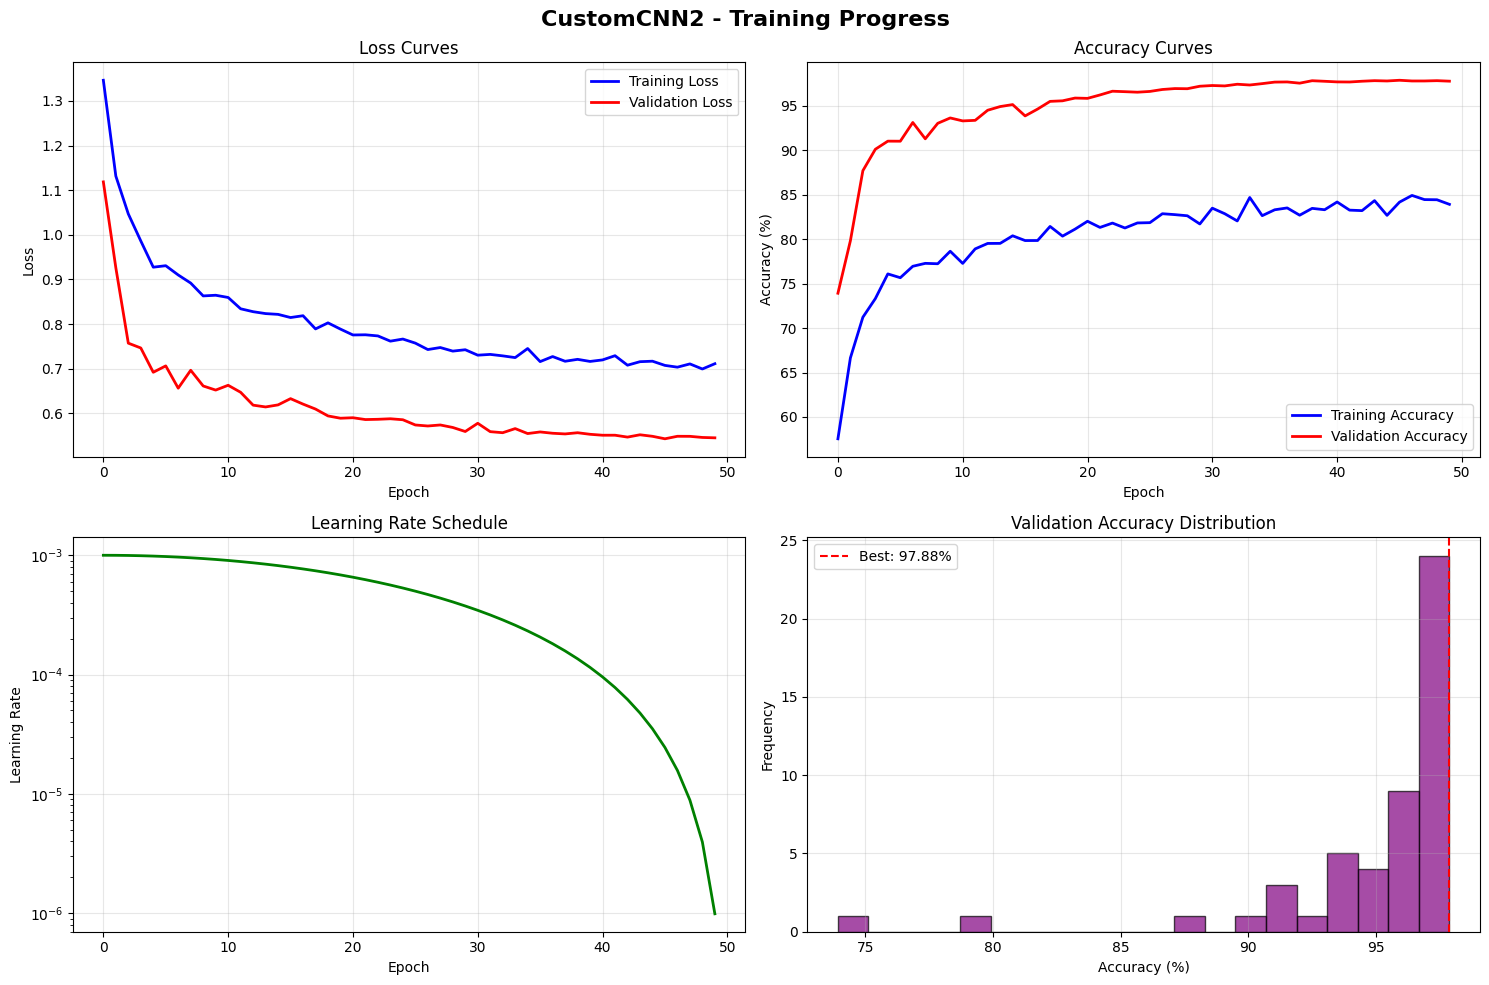

Confusion matrix saved to ./modelos/sprint-4/CustomCNN2_confusion_matrix.png


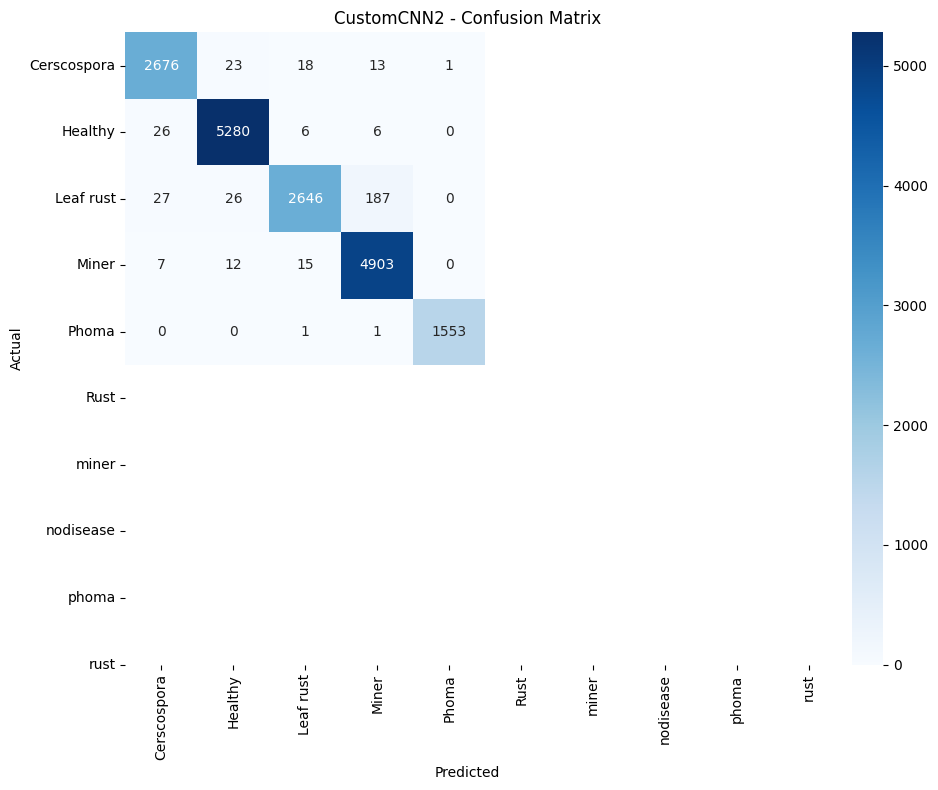

❌ Error training CustomCNN2: Number of classes, 5, does not match size of target_names, 10. Try specifying the labels parameter

🔄 Training CustomCNN3...
--------------------------------------------------

🔧 Training: CustomCNN3
🚀 Starting training for CustomCNN3
Epochs: 50
Learning rate: 0.001
Scheduler: cosine
Mixed precision: True
Advanced augmentation: True
------------------------------------------------------------


CustomCNN3 Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:55<00:00, 22.73it/s]


Epoch 1/50:
  Train Loss: 1.1447, Train Acc: 65.66%
  Val Loss: 0.8159, Val Acc: 87.09%
  Learning Rate: 0.001000
------------------------------------------------------------


CustomCNN3 Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.01it/s]


Epoch 2/50:
  Train Loss: 1.0031, Train Acc: 72.32%
  Val Loss: 0.8216, Val Acc: 84.84%
  Learning Rate: 0.000999
------------------------------------------------------------


CustomCNN3 Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:52<00:00, 24.42it/s]


Epoch 3/50:
  Train Loss: 0.9477, Train Acc: 75.31%
  Val Loss: 0.7304, Val Acc: 90.85%
  Learning Rate: 0.000996
------------------------------------------------------------


CustomCNN3 Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:53<00:00, 23.89it/s]


Epoch 4/50:
  Train Loss: 0.9002, Train Acc: 76.06%
  Val Loss: 0.7097, Val Acc: 90.90%
  Learning Rate: 0.000991
------------------------------------------------------------


CustomCNN3 Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:53<00:00, 23.81it/s]


Epoch 5/50:
  Train Loss: 0.8765, Train Acc: 77.66%
  Val Loss: 0.6606, Val Acc: 93.30%
  Learning Rate: 0.000984
------------------------------------------------------------


CustomCNN3 Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.16it/s]


Epoch 6/50:
  Train Loss: 0.8534, Train Acc: 77.68%
  Val Loss: 0.6560, Val Acc: 94.00%
  Learning Rate: 0.000976
------------------------------------------------------------


CustomCNN3 Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.30it/s]


Epoch 7/50:
  Train Loss: 0.8371, Train Acc: 79.86%
  Val Loss: 0.6529, Val Acc: 94.53%
  Learning Rate: 0.000965
------------------------------------------------------------


CustomCNN3 Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.11it/s]


Epoch 8/50:
  Train Loss: 0.8347, Train Acc: 79.65%
  Val Loss: 0.6370, Val Acc: 94.59%
  Learning Rate: 0.000952
------------------------------------------------------------


CustomCNN3 Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:54<00:00, 23.35it/s]


Epoch 9/50:
  Train Loss: 0.8033, Train Acc: 81.49%
  Val Loss: 0.6235, Val Acc: 95.54%
  Learning Rate: 0.000938
------------------------------------------------------------


CustomCNN3 Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.21it/s]


Epoch 10/50:
  Train Loss: 0.8019, Train Acc: 81.05%
  Val Loss: 0.6078, Val Acc: 95.63%
  Learning Rate: 0.000922
------------------------------------------------------------


CustomCNN3 Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:54<00:00, 23.53it/s]


Epoch 11/50:
  Train Loss: 0.8099, Train Acc: 80.46%
  Val Loss: 0.6131, Val Acc: 95.54%
  Learning Rate: 0.000905
------------------------------------------------------------


CustomCNN3 Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.40it/s]


Epoch 12/50:
  Train Loss: 0.7926, Train Acc: 81.77%
  Val Loss: 0.5983, Val Acc: 96.30%
  Learning Rate: 0.000885
------------------------------------------------------------


CustomCNN3 Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.21it/s]


Epoch 13/50:
  Train Loss: 0.7866, Train Acc: 81.84%
  Val Loss: 0.5973, Val Acc: 96.22%
  Learning Rate: 0.000864
------------------------------------------------------------


CustomCNN3 Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:51<00:00, 24.71it/s]


Epoch 14/50:
  Train Loss: 0.7627, Train Acc: 82.40%
  Val Loss: 0.5859, Val Acc: 96.58%
  Learning Rate: 0.000842
------------------------------------------------------------


CustomCNN3 Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.15it/s]


Epoch 15/50:
  Train Loss: 0.7709, Train Acc: 83.55%
  Val Loss: 0.5827, Val Acc: 96.69%
  Learning Rate: 0.000819
------------------------------------------------------------


CustomCNN3 Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.19it/s]


Epoch 16/50:
  Train Loss: 0.7683, Train Acc: 81.15%
  Val Loss: 0.5800, Val Acc: 96.86%
  Learning Rate: 0.000794
------------------------------------------------------------


CustomCNN3 Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.27it/s]


Epoch 17/50:
  Train Loss: 0.7511, Train Acc: 83.74%
  Val Loss: 0.5760, Val Acc: 96.99%
  Learning Rate: 0.000768
------------------------------------------------------------


CustomCNN3 Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.19it/s]


Epoch 18/50:
  Train Loss: 0.7632, Train Acc: 82.72%
  Val Loss: 0.5696, Val Acc: 97.08%
  Learning Rate: 0.000741
------------------------------------------------------------


CustomCNN3 Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.15it/s]


Epoch 19/50:
  Train Loss: 0.7537, Train Acc: 82.46%
  Val Loss: 0.5675, Val Acc: 97.39%
  Learning Rate: 0.000713
------------------------------------------------------------


CustomCNN3 Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:51<00:00, 24.77it/s]


Epoch 20/50:
  Train Loss: 0.7486, Train Acc: 83.71%
  Val Loss: 0.5734, Val Acc: 97.27%
  Learning Rate: 0.000684
------------------------------------------------------------


CustomCNN3 Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.16it/s]


Epoch 21/50:
  Train Loss: 0.7528, Train Acc: 83.24%
  Val Loss: 0.5632, Val Acc: 97.54%
  Learning Rate: 0.000655
------------------------------------------------------------


CustomCNN3 Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.08it/s]


Epoch 22/50:
  Train Loss: 0.7380, Train Acc: 83.27%
  Val Loss: 0.5625, Val Acc: 97.58%
  Learning Rate: 0.000624
------------------------------------------------------------


CustomCNN3 Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:51<00:00, 24.91it/s]


Epoch 23/50:
  Train Loss: 0.7329, Train Acc: 81.97%
  Val Loss: 0.5713, Val Acc: 97.22%
  Learning Rate: 0.000594
------------------------------------------------------------


CustomCNN3 Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.32it/s]


Epoch 24/50:
  Train Loss: 0.7160, Train Acc: 83.53%
  Val Loss: 0.5663, Val Acc: 97.11%
  Learning Rate: 0.000563
------------------------------------------------------------


CustomCNN3 Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.07it/s]


Epoch 25/50:
  Train Loss: 0.7307, Train Acc: 83.75%
  Val Loss: 0.5668, Val Acc: 97.48%
  Learning Rate: 0.000531
------------------------------------------------------------


CustomCNN3 Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.37it/s]


Epoch 26/50:
  Train Loss: 0.7290, Train Acc: 83.62%
  Val Loss: 0.5595, Val Acc: 97.70%
  Learning Rate: 0.000500
------------------------------------------------------------


CustomCNN3 Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.50it/s]


Epoch 27/50:
  Train Loss: 0.7301, Train Acc: 83.56%
  Val Loss: 0.5606, Val Acc: 97.65%
  Learning Rate: 0.000469
------------------------------------------------------------


CustomCNN3 Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:51<00:00, 24.89it/s]


Epoch 28/50:
  Train Loss: 0.7327, Train Acc: 82.93%
  Val Loss: 0.5582, Val Acc: 97.69%
  Learning Rate: 0.000437
------------------------------------------------------------


CustomCNN3 Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.53it/s]


Epoch 29/50:
  Train Loss: 0.7275, Train Acc: 83.97%
  Val Loss: 0.5685, Val Acc: 97.58%
  Learning Rate: 0.000406
------------------------------------------------------------


CustomCNN3 Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.31it/s]


Epoch 30/50:
  Train Loss: 0.7224, Train Acc: 82.62%
  Val Loss: 0.5549, Val Acc: 97.75%
  Learning Rate: 0.000376
------------------------------------------------------------


CustomCNN3 Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.30it/s]


Epoch 31/50:
  Train Loss: 0.7236, Train Acc: 84.40%
  Val Loss: 0.5530, Val Acc: 97.80%
  Learning Rate: 0.000345
------------------------------------------------------------


CustomCNN3 Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.31it/s]


Epoch 32/50:
  Train Loss: 0.7084, Train Acc: 82.95%
  Val Loss: 0.5523, Val Acc: 97.81%
  Learning Rate: 0.000316
------------------------------------------------------------


CustomCNN3 Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.30it/s]


Epoch 33/50:
  Train Loss: 0.7240, Train Acc: 83.20%
  Val Loss: 0.5501, Val Acc: 97.88%
  Learning Rate: 0.000287
------------------------------------------------------------


CustomCNN3 Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.40it/s]


Epoch 34/50:
  Train Loss: 0.7146, Train Acc: 84.59%
  Val Loss: 0.5558, Val Acc: 97.91%
  Learning Rate: 0.000259
------------------------------------------------------------


CustomCNN3 Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.65it/s]


Epoch 35/50:
  Train Loss: 0.7161, Train Acc: 83.49%
  Val Loss: 0.5505, Val Acc: 97.91%
  Learning Rate: 0.000232
------------------------------------------------------------


CustomCNN3 Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.72it/s]


Epoch 36/50:
  Train Loss: 0.7094, Train Acc: 84.15%
  Val Loss: 0.5503, Val Acc: 97.95%
  Learning Rate: 0.000206
------------------------------------------------------------


CustomCNN3 Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.49it/s]


Epoch 37/50:
  Train Loss: 0.7139, Train Acc: 83.79%
  Val Loss: 0.5520, Val Acc: 97.88%
  Learning Rate: 0.000181
------------------------------------------------------------


CustomCNN3 Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.37it/s]


Epoch 38/50:
  Train Loss: 0.7259, Train Acc: 82.56%
  Val Loss: 0.5521, Val Acc: 97.93%
  Learning Rate: 0.000158
------------------------------------------------------------


CustomCNN3 Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.17it/s]


Epoch 39/50:
  Train Loss: 0.7063, Train Acc: 83.65%
  Val Loss: 0.5529, Val Acc: 97.71%
  Learning Rate: 0.000136
------------------------------------------------------------


CustomCNN3 Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 24.97it/s]


Epoch 40/50:
  Train Loss: 0.7102, Train Acc: 84.53%
  Val Loss: 0.5537, Val Acc: 97.91%
  Learning Rate: 0.000115
------------------------------------------------------------


CustomCNN3 Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:51<00:00, 24.83it/s]


Epoch 41/50:
  Train Loss: 0.7165, Train Acc: 82.16%
  Val Loss: 0.5577, Val Acc: 97.87%
  Learning Rate: 0.000095
------------------------------------------------------------


CustomCNN3 Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.15it/s]


Epoch 42/50:
  Train Loss: 0.7122, Train Acc: 82.87%
  Val Loss: 0.5462, Val Acc: 97.97%
  Learning Rate: 0.000078
------------------------------------------------------------


CustomCNN3 Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.15it/s]


Epoch 43/50:
  Train Loss: 0.7085, Train Acc: 85.00%
  Val Loss: 0.5534, Val Acc: 98.09%
  Learning Rate: 0.000062
------------------------------------------------------------


CustomCNN3 Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.31it/s]


Epoch 44/50:
  Train Loss: 0.7031, Train Acc: 84.59%
  Val Loss: 0.5472, Val Acc: 98.05%
  Learning Rate: 0.000048
------------------------------------------------------------


CustomCNN3 Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.64it/s]


Epoch 45/50:
  Train Loss: 0.7105, Train Acc: 83.12%
  Val Loss: 0.5532, Val Acc: 97.91%
  Learning Rate: 0.000035
------------------------------------------------------------


CustomCNN3 Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.74it/s]


Epoch 46/50:
  Train Loss: 0.7155, Train Acc: 84.73%
  Val Loss: 0.5514, Val Acc: 97.84%
  Learning Rate: 0.000024
------------------------------------------------------------


CustomCNN3 Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.02it/s]


Epoch 47/50:
  Train Loss: 0.7051, Train Acc: 85.32%
  Val Loss: 0.5495, Val Acc: 97.91%
  Learning Rate: 0.000016
------------------------------------------------------------


CustomCNN3 Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:49<00:00, 25.84it/s]


Epoch 48/50:
  Train Loss: 0.7078, Train Acc: 82.59%
  Val Loss: 0.5531, Val Acc: 97.99%
  Learning Rate: 0.000009
------------------------------------------------------------


CustomCNN3 Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 25.11it/s]


Epoch 49/50:
  Train Loss: 0.7057, Train Acc: 83.76%
  Val Loss: 0.5472, Val Acc: 98.04%
  Learning Rate: 0.000004
------------------------------------------------------------


CustomCNN3 Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:50<00:00, 24.97it/s]


Epoch 50/50:
  Train Loss: 0.7142, Train Acc: 84.60%
  Val Loss: 0.5455, Val Acc: 98.03%
  Learning Rate: 0.000001
------------------------------------------------------------
✅ Training completed!
Total training time: 59.47 minutes
Best validation accuracy: 98.09% at epoch 43
✅ CustomCNN3 saved to ./modelos/sprint-4/CustomCNN3_best.pth
Training curves saved to ./modelos/sprint-4/CustomCNN3_training_curves.png


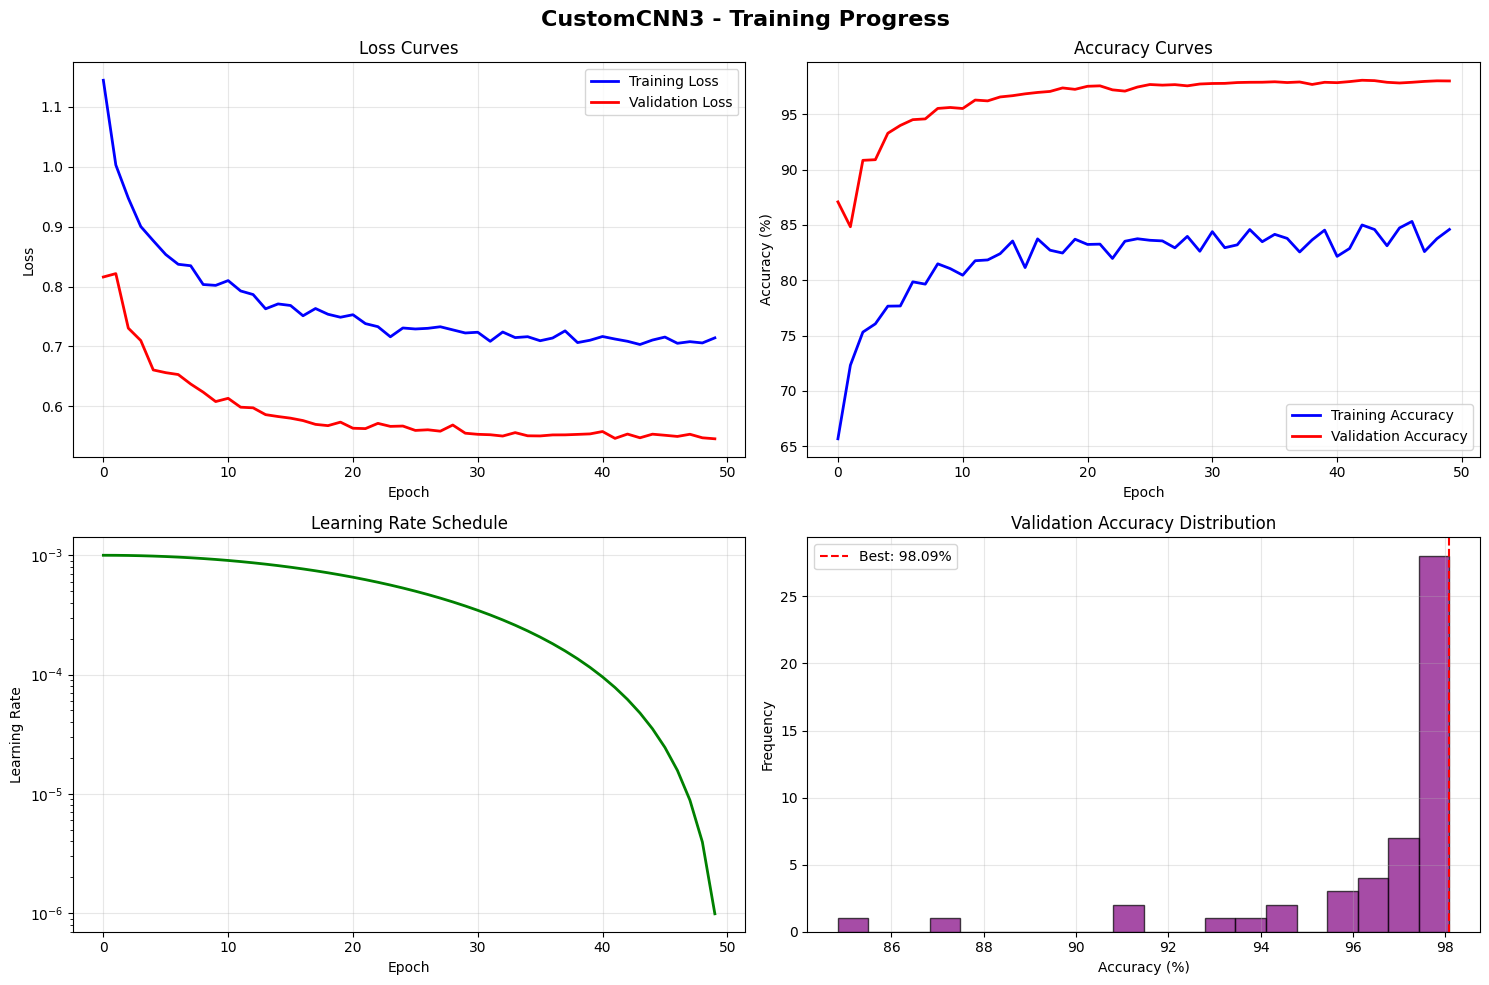

Confusion matrix saved to ./modelos/sprint-4/CustomCNN3_confusion_matrix.png


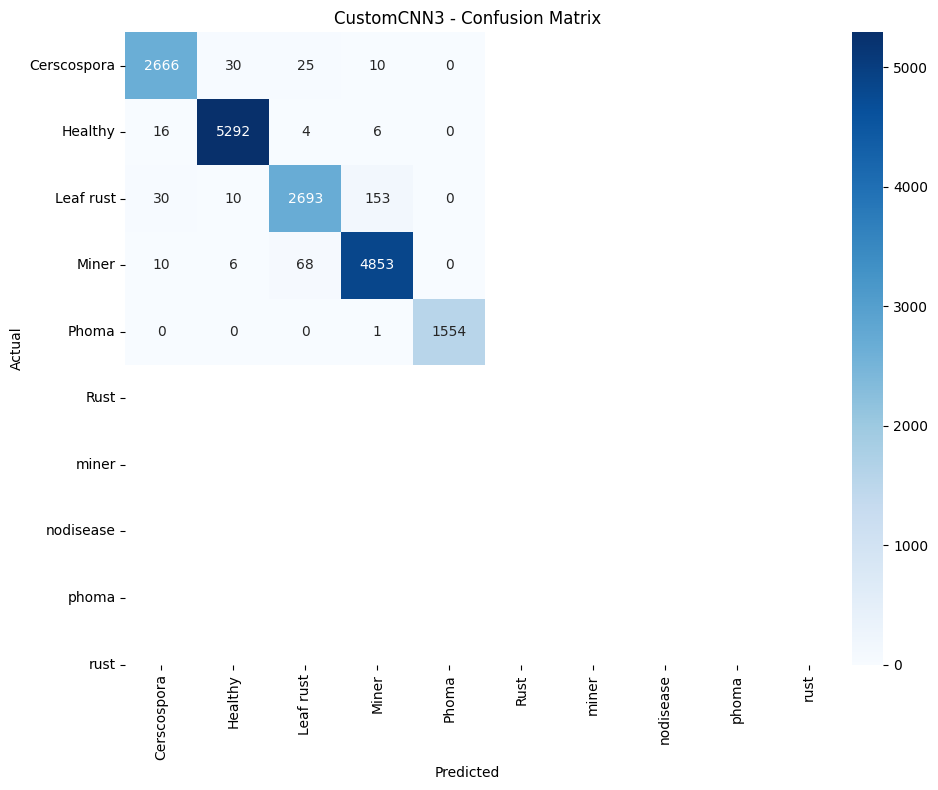

❌ Error training CustomCNN3: Number of classes, 5, does not match size of target_names, 10. Try specifying the labels parameter

🎉 Training pipeline completed!
Trained models: ['CustomCNN1', 'CustomCNN2', 'CustomCNN3']
Results saved to: ./modelos/sprint-4
Model comparison saved to ./modelos/sprint-4/model_comparison.png


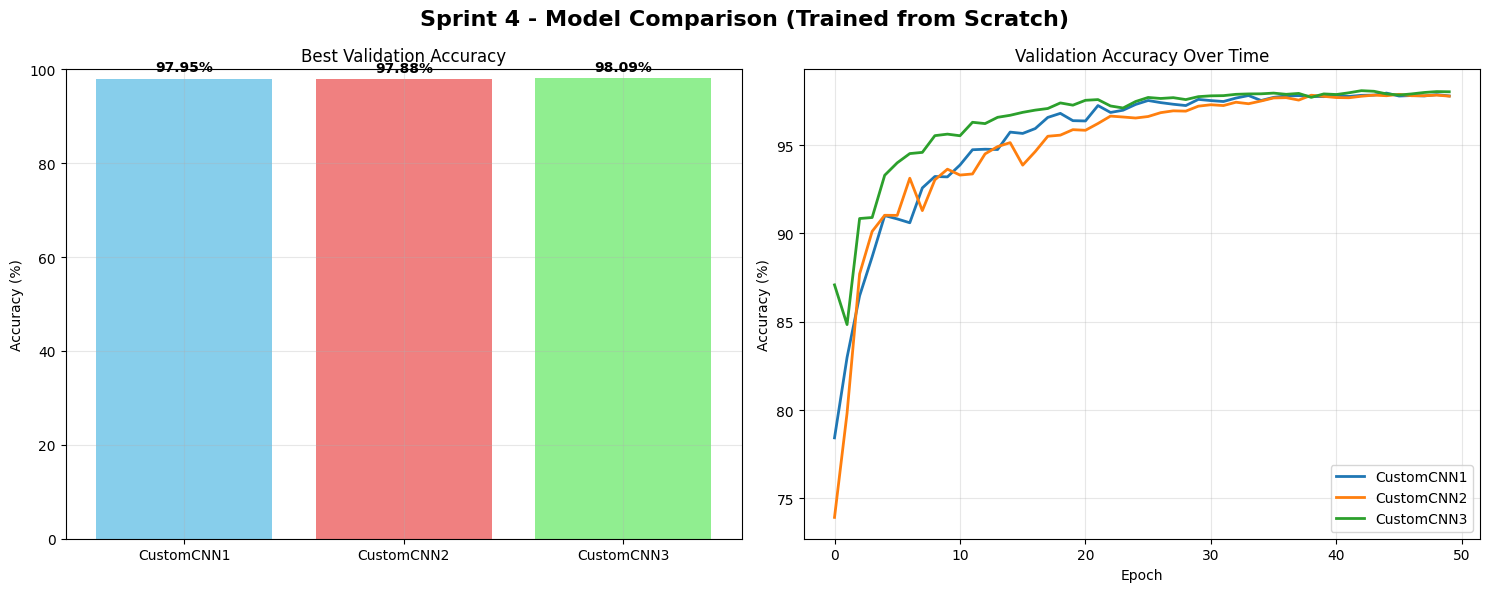


📊 Final Results Summary:
CustomCNN1: Best Accuracy = 97.95% at epoch 45
CustomCNN2: Best Accuracy = 97.88% at epoch 46
CustomCNN3: Best Accuracy = 98.09% at epoch 43


In [10]:
# Train and Evaluate All Custom CNN Models
results = {}
all_metrics = {}

for name, model in models_dict.items():
    print(f"\n🔄 Training {name}...")
    print("-" * 50)
    
    try:
        # Train model
        trained_model, metrics = train_and_evaluate_model(
            model, name, train_loader, val_loader, CONFIG
        )
        
        # Store results
        results[name] = trained_model
        all_metrics[name] = metrics
        
        # Save model
        model_path = os.path.join(CONFIG['save_dir'], f'{name}_best.pth')
        torch.save(trained_model.state_dict(), model_path)
        print(f"✅ {name} saved to {model_path}")
        
        # Plot training curves
        plot_training_curves(metrics, name, 
                           os.path.join(CONFIG['save_dir'], f'{name}_training_curves.png'))
        
        # Plot confusion matrix
        plot_confusion_matrix(trained_model, val_loader, CONFIG['class_names'], name,
                            os.path.join(CONFIG['save_dir'], f'{name}_confusion_matrix.png'))
        
    except Exception as e:
        print(f"❌ Error training {name}: {e}")
        continue

print("\n" + "=" * 80)
print("🎉 Training pipeline completed!")
print(f"Trained models: {list(results.keys())}")
print(f"Results saved to: {CONFIG['save_dir']}")

# Plot model comparison
if all_metrics:
    plot_model_comparison(all_metrics, 
                        os.path.join(CONFIG['save_dir'], 'model_comparison.png'))

print("\n📊 Final Results Summary:")
for name, metrics in all_metrics.items():
    best_epoch, best_acc = metrics.get_best_epoch()
    print(f"{name}: Best Accuracy = {best_acc:.2f}% at epoch {best_epoch+1}")


## 📋 Resumo e Conclusões - Sprint 4

### Melhorias Implementadas em relação à Sprint 1:

1. **Treinamento do Zero**: 
   - Modelos customizados treinados do zero (não transfer learning)
   - 3 arquiteturas diferentes: CustomCNN1, CustomCNN2, CustomCNN3

2. **Data Augmentation Avançada**:
   - Mixup e CutMix para regularização
   - Transformações geométricas e de cor mais robustas
   - Random Erasing para melhor generalização

3. **Arquiteturas Customizadas**:
   - **CustomCNN1**: Lightweight mas eficaz
   - **CustomCNN2**: Deeper com conexões residuais
   - **CustomCNN3**: EfficientNet-inspired com MBConv blocks

4. **Técnicas de Treinamento Avançadas**:
   - Label smoothing para melhor generalização
   - Learning rate scheduling (Cosine Annealing)
   - Early stopping para prevenir overfitting
   - Mixed precision training para eficiência
   - Gradient clipping para estabilidade
   - AdamW optimizer com weight decay

5. **Métricas e Visualizações**:
   - Acompanhamento detalhado de métricas
   - Visualizações abrangentes de treinamento
   - Matrizes de confusão detalhadas
   - Comparação entre modelos

### Principais Diferenças da Sprint 1:

- **Transfer Learning vs From Scratch**: Sprint 1 usava modelos pré-treinados, Sprint 4 treina do zero
- **Arquiteturas**: Sprint 4 usa CNNs customizadas otimizadas para o problema
- **Data Augmentation**: Sprint 4 implementa técnicas mais avançadas (Mixup, CutMix)
- **Técnicas de Treinamento**: Sprint 4 usa técnicas mais modernas e robustas
- **Visualizações**: Sprint 4 tem visualizações mais detalhadas e informativas

### Próximos Passos:
- Análise dos resultados obtidos
- Identificação do melhor modelo
- Possíveis ajustes finos baseados nos resultados
- Comparação com modelos da Sprint 1
- Preparação para deploy ou produção
